In [3]:
from base import *
from utils import *
from plot_tools import *
import qiskit as qk
from qiskit import QuantumCircuit, Aer, execute
from qiskit.primitives import Estimator
# from qiskit.utils import QuantumInstance
# from qiskit.algorithms import VQE
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.algorithms.optimizers import SLSQP, ADAM
from qiskit.opflow import PauliSumOp, AerPauliExpectation
from qiskit.circuit import Parameter
import numpy as np
import seaborn as sns



## The simple hamiltonian
$$
H_0 = \mathcal{E} I + \Omega \sigma_z, \quad \mathcal{E} = \frac{E_1
  + E_2}{2}, \; \Omega = \frac{E_1-E_2}{2},
$$
$$
H_I = c \boldsymbol{I} +\omega_z\sigma_z + \omega_x\sigma_x,
$$
$$
c = (V_{11}+V_{22})/2, 
$$ 
$$
\omega_z = (V_{11}-V_{22})/2, 
$$
$$
\omega_x = V_{12}=V_{21}
$$

In [4]:
# Constants
E_1 = 0
E_2 = 4 
V_11 = 3
V_22 = -3
V_12 = 0.2
V_21 = 0.2
epsilon = (E_1+E_2) / 2
Omega = (E_1-E_2) / 2
c = (V_11 + V_22) / 2
omega_z = (V_11 - V_22) / 2
omega_x = V_12

# Variables
# lmb = 1 # Interaction strength


### Classical numerical solver for the eigenvalues

In [5]:
H_0 = np.array([[E_1, 0],
               [0, E_2]])
H_1 = np.array([[V_11, V_12],
               [V_21, V_22]])


lmbs = np.arange(0, 1, 0.001)
eigs = np.zeros((2, len(lmbs)))

for i, lmb in enumerate(lmbs):
    result = np.linalg.eig(H_0 + lmb * H_1)[0]
    eigs[:,i] = max(result), min(result)

# print(eigs)
# print(lmbs.shape)
plt.plot(lmbs, eigs[0], label='E_0')
plt.plot(lmbs, eigs[1], label='E_1')
plt.plot(np.array([2/3 for _ in range(100)]), np.linspace(0, 4, 100), label=r'$\lambda=2/3$'),
plt.xlabel(r'$\lambda$')
plt.ylabel(r'Eigenvalues')
plt.legend()
save_fig('eigs-1-cl.pdf')


### Quantum Computing 

First we need to rewrite the hamiltonian in terms of Pauli matrices.
$$
H_0 = \mathcal{E} I + \Omega \sigma_z, \quad 
\mathcal{E} = \frac{E_1+ E_2}{2}, \; \Omega = \frac{E_1-E_2}{2},
$$
$$
H_I = c \boldsymbol{I} +\omega_z\sigma_z + \omega_x\sigma_x,
$$
$$
\lambda H_I = \lambda c \boldsymbol{I} + \lambda \omega_z\sigma_z + \lambda \omega_x \sigma_x 
$$
$$
H = H_0 + \lambda H_I = \left( \mathcal{E} + \lambda c \right) I + (\Omega + \lambda \omega_z)\sigma_z + (\lambda \omega_x)\sigma_x
$$

In [6]:
q2 = Qubits_2()

# set up bell state
q2.hadamard(0)
q2.measure(1000)

array([[501.,   0.],
       [  0.,   1.],
       [499.,  10.],
       [  0.,  11.]])

Set up

In [15]:

def H(lmb):
    return PauliSumOp.from_list([('X', lmb*omega_x), 
                                 ('Z', Omega+lmb*omega_z), 
                                 ('I', lmb*c+epsilon)]) # Hamiltonian using operators

def ansatz():
    # creates an ansatz that are functions of the parameters TODO: maybe can be changed to Hartree Fock initial state? 
    # from HartreeFock.construct_circuit()
    theta = Parameter('theta')
    phi = Parameter('phi')
    qc = QuantumCircuit(1)
    qc.rx(theta,0)
    qc.ry(phi,0)
    return qc


def prep_vqe():
    adam = ADAM(maxiter = 10000)
    slsqp = SLSQP(maxiter=10000)
    # backend = Aer.get_backend('qasm_simulator')
    estimator = Estimator()

    vqe = VQE(ansatz=ansatz(), 
              optimizer=slsqp, 
              initial_point=np.random.uniform(low=-np.pi, high=np.pi, size=2), 
              estimator=estimator)

    return vqe
# vqe is sucessful becuase we enbed 2 qubit gates which, which creates highly entangled states. 
# Allowing us to explore multiple states at the same time. thetas needed for an n_qubit state doesn't have to scale exponentially with the number of qubits, but only linearly.



In [16]:
# Define the backend to run the quantum circuit
n_points=100


lmbs = np.arange(n_points) # rmb to divide when used
vqe = prep_vqe()
energies = np.zeros(n_points) # containers for the energies

for i, lmb in enumerate(lmbs):
    lmb = lmb / n_points
    ham = H(lmb)
    # print(ham)
    result = vqe.compute_minimum_eigenvalue(ham)
    energies[i] = result.eigenvalue.real
    print(f'lmb = {lmb}, energy = {result.eigenvalue.real}')




lmb = 0.0, energy = 4.393766506183283e-08
lmb = 0.01, energy = 0.029999021431303508
lmb = 0.02, energy = 0.059995900270810365
lmb = 0.03, energy = 0.08999058813392447
lmb = 0.04, energy = 0.11998298311054367
lmb = 0.05, energy = 0.14997297669069587
lmb = 0.06, energy = 0.17996044239390008
lmb = 0.07, energy = 0.2099452538048514
lmb = 0.08, energy = 0.23992727922316903
lmb = 0.09, energy = 0.26990639134545513
lmb = 0.1, energy = 0.29988238460629746
lmb = 0.11, energy = 0.32985514733005306
lmb = 0.12, energy = 0.35982467542338115
lmb = 0.13, energy = 0.38979007623072914
lmb = 0.14, energy = 0.4197519191261023
lmb = 0.15, energy = 0.4497097082689041
lmb = 0.16, energy = 0.47966320150915465
lmb = 0.17, energy = 0.509612146871294
lmb = 0.18, energy = 0.5395562488690178
lmb = 0.19, energy = 0.5694952106686908
lmb = 0.2, energy = 0.5994287046456579
lmb = 0.21, energy = 0.62935637256718
lmb = 0.22, energy = 0.6592778239427886
lmb = 0.23, energy = 0.6891926328000977
lmb = 0.24, energy = 0.71910

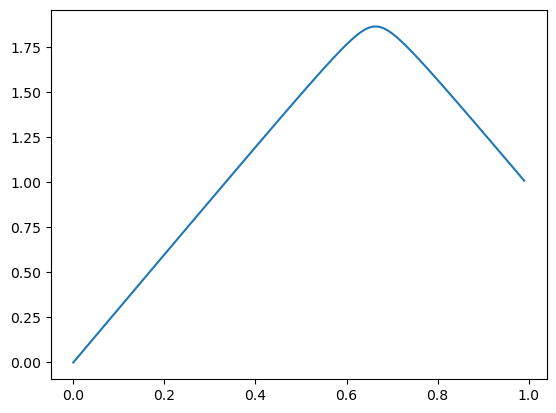

In [17]:
plt.plot(lmbs/n_points, energies)
# save_fig('qk-1qb.pdf')
plt.show()

With **src.base**
$$
H = H_0 + \lambda H_I = \left( \mathcal{E} + \lambda c \right) I + (\Omega + \lambda \omega_z)\sigma_z + (\lambda \omega_x)\sigma_x
$$

In [18]:

def my_ansatz(params):
    '''params: list of parameters for the ansatz, [theta, phi]'''
    qc = Qubit()
    qc.rx(params[0], 0)
    qc.ry(params[1], 0)
    return qc

def my_H(lmb):
    # computes the hamiltonian
    return pauli_sum([('X', lmb*omega_x), 
                      ('Z', Omega+lmb*omega_z), 
                      ('I', lmb*c+epsilon)])

def expectation(qc, lmb, n_shots=10000):

    coeffs = {'X': lmb*omega_x, 
            'Z': Omega+lmb*omega_z, 
            'I': lmb*c+epsilon}
    
    qc_copy = qc.copy()
    qc_copy.hadamard(0)
    count_x = qc_copy.measure(n_shots)[:, 0]

    qc_copy = qc.copy()
    count_z = qc_copy.measure(n_shots)[:, 0]

    expt = 0
    count_x *= coeffs['X']
    count_z *= coeffs['Z']

    expt += count_x[0]
    expt -= count_x[1]
    
    expt += count_z[0]
    expt -= count_z[1]

    return coeffs['I'] + expt / n_shots

qc = Qubit()
expectation(qc, 0.5)

1.50104

In [11]:
a = my_ansatz((np.pi/2,np.pi/2))
a

Qubit(s) in state: 
 0.50+0.50j|0⟩ + 0.50-0.50j|1⟩ 

In [12]:
from algorithms import Vqe 

In [19]:
n_points = 100

init_points = np.random.uniform(low=-np.pi, high=np.pi, size=2)
my_vqe = Vqe(my_ansatz, init_points, expectation=expectation)

my_energies = np.zeros(n_points)
lmbs = np.arange(n_points)
for i, lmb in enumerate(lmbs):
    lmb = lmb / n_points
    print(lmb)
    my_ham = my_H(lmb)
    print(my_ham)
    min_params, min_energy = my_vqe.minimise_eigenvalue(my_ham, lmb)
    print(f"lambda: {lmb}, energy: {min_energy}")
    my_energies[i] = min_energy



0.0
[[0. 0.]
 [0. 4.]]
lambda: 0.0, energy: 0.00390625
0.01
[[3.00e-02 2.00e-03]
 [2.00e-03 3.97e+00]]
lambda: 0.01, energy: 0.02998828125000008
0.02
[[0.06  0.004]
 [0.004 3.94 ]]
lambda: 0.02, energy: 0.05954687500000011
0.03
[[0.09  0.006]
 [0.006 3.91 ]]
lambda: 0.03, energy: 0.08949609375
0.04
[[0.12  0.008]
 [0.008 3.88 ]]
lambda: 0.04, energy: 0.11953125000000009
0.05
[[0.15 0.01]
 [0.01 3.85]]
lambda: 0.05, energy: 0.15203124999999984
0.06
[[0.18  0.012]
 [0.012 3.82 ]]
lambda: 0.06, energy: 0.17971874999999993
0.07
[[0.21  0.014]
 [0.014 3.79 ]]
lambda: 0.07, energy: 0.20917968750000004
0.08
[[0.24  0.016]
 [0.016 3.76 ]]
lambda: 0.08, energy: 0.24046875
0.09
[[0.27  0.018]
 [0.018 3.73 ]]
lambda: 0.09, energy: 0.26876953125
0.1
[[0.3  0.02]
 [0.02 3.7 ]]
lambda: 0.1, energy: 0.2989453125000001
0.11
[[0.33  0.022]
 [0.022 3.67 ]]
lambda: 0.11, energy: 0.32892578125000016
0.12
[[0.36  0.024]
 [0.024 3.64 ]]
lambda: 0.12, energy: 0.35892187499999983
0.13
[[0.39  0.026]
 [0.026 3

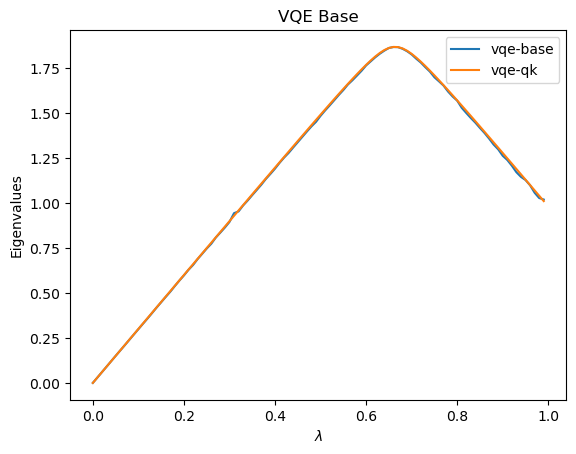

In [14]:

plt.plot(lmbs/n_points, my_energies, label='vqe-base')
plt.plot(lmbs/n_points, energies, label='vqe-qk')
# plt.plot(2/3* np.ones(n_points), np.linspace(min(my_energies), 1.01*max(my_energies), n_points), label=r'$\lambda=2/3$')

plt.xlabel(r'$\lambda$')
plt.ylabel('Eigenvalues')
plt.title('VQE Base')
plt.legend()
plt.show()